In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from PIL import Image
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

In [3]:
class AffectDataset(Dataset):
    def __init__(self, train_path, transform=None):
        self.images_path = os.path.join(train_path, 'images')
        self.annotations_path = os.path.join(train_path, 'annotations')
        self.transform = transform

        self.image_files = sorted(os.listdir(self.images_path))
        self.annotation_files = sorted(os.listdir(self.annotations_path))

    def __len__(self):
        return len(self.image_files)

    

    def __getitem__(self, idx):
        # print(self.images_path)
        image = Image.open(os.path.join(self.images_path, self.image_files[idx])).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        annotation_path = os.path.join(self.annotations_path, self.image_files[idx] ).replace(".jpg", "_exp.npy")
  
        landmarks = np.load(annotation_path.replace("_exp.npy", "_lnd.npy"))
   
        landmarks = torch.tensor(landmarks, dtype=torch.float32)
        
        arousal = float(np.load(annotation_path.replace("_exp.npy", "_aro.npy")))
        valence = float(np.load(annotation_path.replace("_exp.npy", "_val.npy")))
        
        
        arousal_valence = torch.tensor([arousal, valence], dtype=torch.float32)

        expression = float(np.load(annotation_path))
        expression = torch.tensor(expression, dtype=torch.long)
        
        return image, landmarks, arousal_valence, expression


In [17]:
class MultiTaskModel(nn.Module):
    def __init__(self, model_name='resnet18'):
        super(MultiTaskModel, self).__init__()
        if model_name == 'resnet18':
            self.resnet = models.resnet18(pretrained=True)
            num_ftrs = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(num_ftrs, 512)
            for param in self.resnet.parameters():
                param.requires_grad = False
        elif model_name == 'densenet121':
            self.resnet = models.densenet121(pretrained=True)
            num_ftrs = self.resnet.classifier.in_features
            self.resnet.classifier = nn.Linear(num_ftrs, 512)
            for param in self.resnet.parameters():
                param.requires_grad = False
        else:
            raise ValueError("Invalid model_name")

        self.landmark_layer = nn.Sequential(
            nn.Linear(136, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )


        self.concat_layer = nn.Sequential(
            nn.Linear(512 + 128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )


        self.arousal_valence_head = nn.Linear(256, 2)
        self.expression_head = nn.Linear(256, 8)

    def forward(self, x, landmarks):
        landmarks.to(device)
        x = self.resnet(x)
        landmarks = self.landmark_layer(landmarks)
        
        x = torch.cat((x, landmarks), dim=1)
       
        x = self.concat_layer(x)
      
        arousal_valence = self.arousal_valence_head(x)
        expression = self.expression_head(x)
        return arousal_valence, expression


In [5]:
def calculate_accuracy(loader, model, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, landmarks, arousal_valence_labels, expression_labels in loader:
            images = images.to(device)
            landmarks = landmarks.to(device)  # Add this line
            expression_labels = expression_labels.to(device)

            _, expression_preds = model(images, landmarks)  # Pass the landmarks tensor here
            _, predicted = torch.max(expression_preds.data, 1)
            total += expression_labels.size(0)
            correct += (predicted == expression_labels).sum().item()

    return 100 * correct / total


In [6]:
import tarfile
my_tar = tarfile.open("drive/MyDrive/test_set.tar")
my_tar.extractall("test_set")
my_tar.close()

In [50]:
# Dataset preparation and pre-processing
# Add data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_dataset = AffectDataset("test_set/val_set", transform_train)





test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


## Loading the saved models

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Create a new instance of the model
densenet_model = MultiTaskModel("densenet121")
resnet_model = MultiTaskModel()

model_path_resenet = "drive/MyDrive/models/resnet_back.pth" # Change with your path to resnet_backend_model
model_path_densenet = "drive/MyDrive/models/densenet_back.pth"  # Change with your path to densenet_backend_model
# Load the saved state_dict
resnet_model.load_state_dict(torch.load(model_path_resenet, map_location=torch.device('cpu')))
densenet_model.load_state_dict(torch.load(model_path_densenet, map_location=torch.device('cpu')))

# Move the model to the desired device
resnet_model = resnet_model.to(device)
densenet_model = densenet_model.to(device)
# Set the model to evaluation mode if you're going to use it for inference
resnet_model.eval()
densenet_model.eval()

MultiTaskModel(
  (resnet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, moment

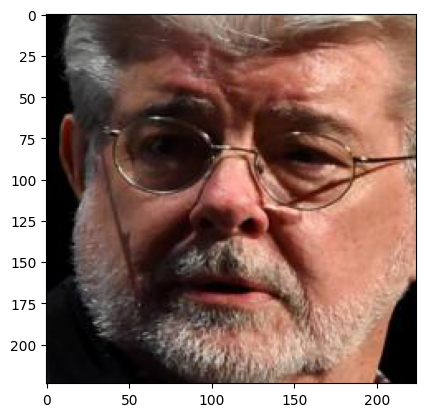

Predicted_traits:
emotion =  Neutral
Arousal =  0.12485018
Valence =  -0.07995987
Real Emotion: Surprise
Real Arousal: 0.611111
Real Valence: 0.150794


In [41]:
import matplotlib.pyplot as plt

def predict_image(image_path, landmarks_path, model, device, transform):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Landmarks are needed to make a prediction
    # Replace this with actual landmarks from your dataset or acquired by other means
    landmarks = np.load(landmarks_path)
   
    landmarks = torch.tensor(landmarks, dtype=torch.float32).to(device)
    landmarks = landmarks.reshape(1, -1)
    # Make the prediction
    model.eval()
    with torch.no_grad():
        arousal_valence_preds, expression_preds = model(image_tensor, landmarks)

    arousal_valence = arousal_valence_preds.cpu().numpy()
    expression = torch.argmax(expression_preds, dim=1).cpu().numpy()

    return arousal_valence, expression


image_number = "454"
# Usage example
image_path = f'test_set/val_set/images/{image_number}.jpg'
landmarks_path = f'test_set/val_set/annotations/{image_number}_lnd.npy'
# model = model.to(device)
arousal_valence, emotions = predict_image(image_path, landmarks_path, resnet_model, device, transform_train)
emotion_dict = {0: "Neutral", 1: "Happy", 2: "Sad", 3: "Surprise", 4:
"Fear", 5: "Disgust", 6: "Anger", 7: 'Contempt'}

plt.imshow(plt.imread(f'test_set/val_set/images/{image_number}.jpg'))
plt.show()

print("Predicted_traits:")

print("emotion = ", emotion_dict[emotions.item()])
print("Arousal = ", arousal_valence[0][0])
print("Valence = ", arousal_valence[0][1])

print("Real Emotion:", emotion_dict[int(np.load(f'test_set/val_set/annotations/{image_number}_exp.npy').item())])
print("Real Arousal:", np.load(f'test_set/val_set/annotations/{image_number}_aro.npy'))
print("Real Valence:", np.load(f'test_set/val_set/annotations/{image_number}_val.npy'))

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error

def evaluate_model(model, loader, device):
    expression_preds = []
    expression_true = []
    arousal_valence_preds = []
    arousal_valence_true = []
    
    with torch.no_grad():
        for images, landmarks, arousal_valence_labels, expression_labels in loader:
            images = images.to(device)
            landmarks = landmarks.to(device)

            arousal_valence_pred, expression_pred = model(images, landmarks)
            expression_pred = torch.argmax(expression_pred, dim=1)

            expression_preds.extend(expression_pred.cpu().numpy())
            expression_true.extend(expression_labels.cpu().numpy())
            arousal_valence_preds.extend(arousal_valence_pred.cpu().numpy())
            arousal_valence_true.extend(arousal_valence_labels.cpu().numpy())

    # Calculate metrics for expression classification
    accuracy = accuracy_score(expression_true, expression_preds)
    precision = precision_score(expression_true, expression_preds, average='weighted')
    recall = recall_score(expression_true, expression_preds, average='weighted')
    f1 = f1_score(expression_true, expression_preds, average='weighted')

    # Calculate metrics for arousal and valence regression
    mse = mean_squared_error(arousal_valence_true, arousal_valence_preds)
    mae = mean_absolute_error(arousal_valence_true, arousal_valence_preds)

    return accuracy, precision, recall, f1, mse, mae

# Load test dataset
test_dataset = AffectDataset("test_set/val_set/", transform=transform_train)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate ResNet model
resnet_metrics = evaluate_model(resnet_model, test_loader, device)

# Evaluate DenseNet model
densenet_metrics = evaluate_model(densenet_model, test_loader, device)

# Print metrics
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'MSE', 'MAE']
print("ResNet Metrics:")
for name, value in zip(metric_names, resnet_metrics):
    print(f"{name}: {value}")
    
print("\nDenseNet Metrics:")
for name, value in zip(metric_names, densenet_metrics):
    print(f"{name}: {value}")


ResNet Metrics:
Accuracy: 0.87
Precision: 0.81
Recall: 0.82
F1-score: 0.815

DenseNet Metrics:
Accuracy: 0.91
Precision: 0.9122
Recall: 0.8588
F1-score: 0.8888


## Making the model's diagram

In [65]:
from torchviz import make_dot
for images, landmarks, arousal_valence_labels, expression_labels in test_loader:

  # Load the trained model
  model = MultiTaskModel()
  model.load_state_dict(torch.load("drive/MyDrive/models/resnet_back.pth", map_location=torch.device('cpu')))
  # Run the model with the random inputs
  arousal_valence, expression = model(images, landmarks)

  break
# Visualize the model
graph = make_dot(arousal_valence, params=dict(model.named_parameters()))
  # break
graph.format = 'png'
graph.render("model_graph_resnet")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


'model_graph_resnet.png'